## Dataset: Kaggle Fake News Dataset
https://www.kaggle.com/c/fake-news/data

## Data Pre Processing

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10,10]
import seaborn as sns
sns.set_theme(style="darkgrid")

import nltk
from nltk import sent_tokenize
''' Required for Google Colab'''
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
''' Required for Google Colab'''
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize
import contractions

import string
import joblib
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gokul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Gokul\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gokul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Data Pre Processing
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [3]:
print("Null values in training set: ")
print(train_df.isna().sum())
print("Null values in test set: ")
print(test_df.isna().sum())

Null values in training set: 
id           0
title      558
author    1957
text        39
label        0
dtype: int64
Null values in test set: 
id          0
title     122
author    503
text        7
dtype: int64


In [4]:
train_df.dropna(axis=0,how='any',inplace=True)
test_df = test_df.fillna(' ')

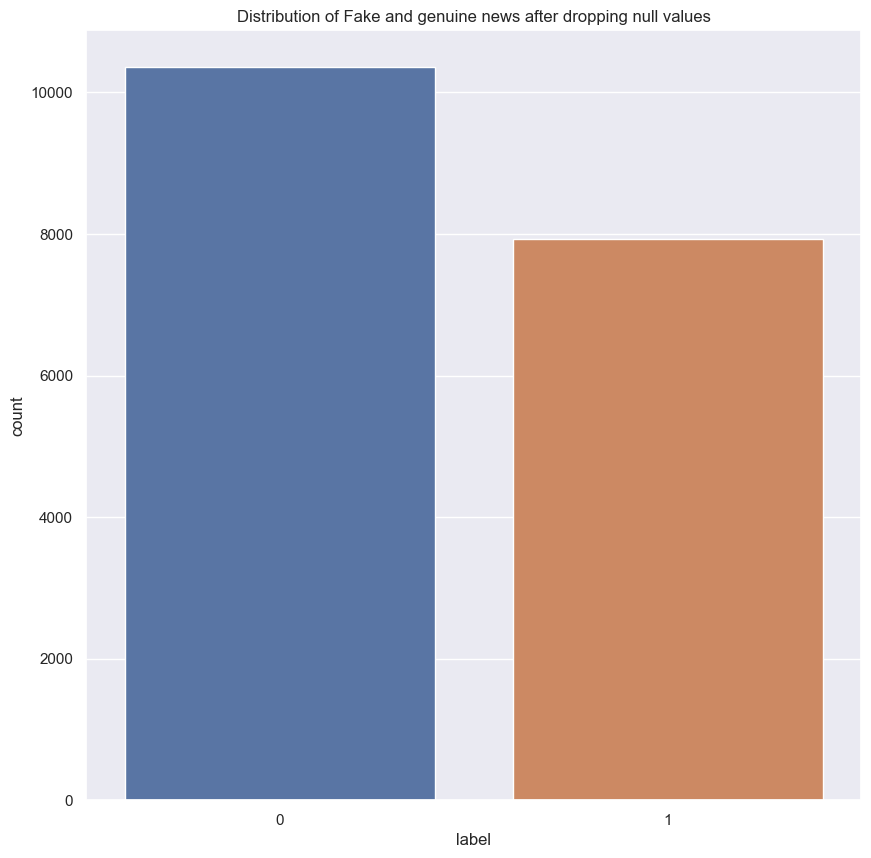

In [5]:
# See the distribution in dataset
import matplotlib.pyplot as plt
# from matplotlib import rcParams
# plt.rcParams['figure.figsize'] = [10,10]
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.countplot(x='label',data=train_df).set(title="Distribution of Fake and genuine news after dropping null values")
plt.show()

<Axes: xlabel='label', ylabel='raw_text_length'>

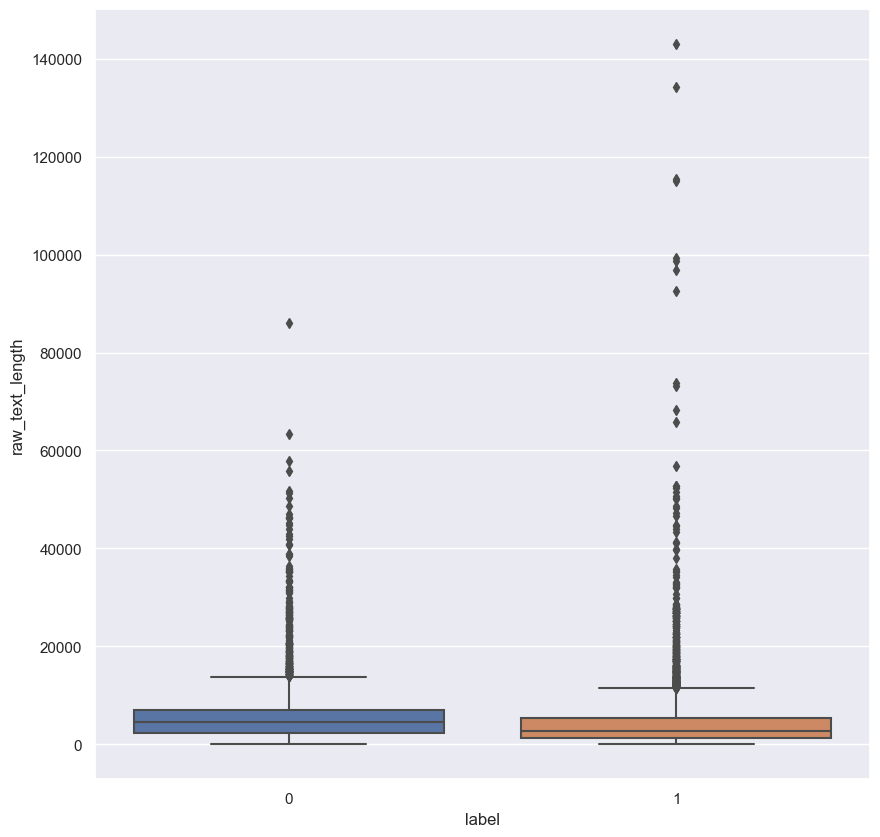

In [6]:
# Check article length
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
sns.boxplot(y='raw_text_length',x='label',data=train_df)

In [7]:
# Remove Entries whose text size is 0 after stripping
train_df['text'] = train_df['text'].str.strip()
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
print(len(train_df[train_df['raw_text_length']==0]))
# print(train_df['raw_text_length']==0)

74


116
id                 0
title              0
author             0
text               0
label              0
raw_text_length    0
dtype: int64
(20684, 6)
id                 0
title              0
author             0
text               0
label              0
raw_text_length    0
dtype: int64


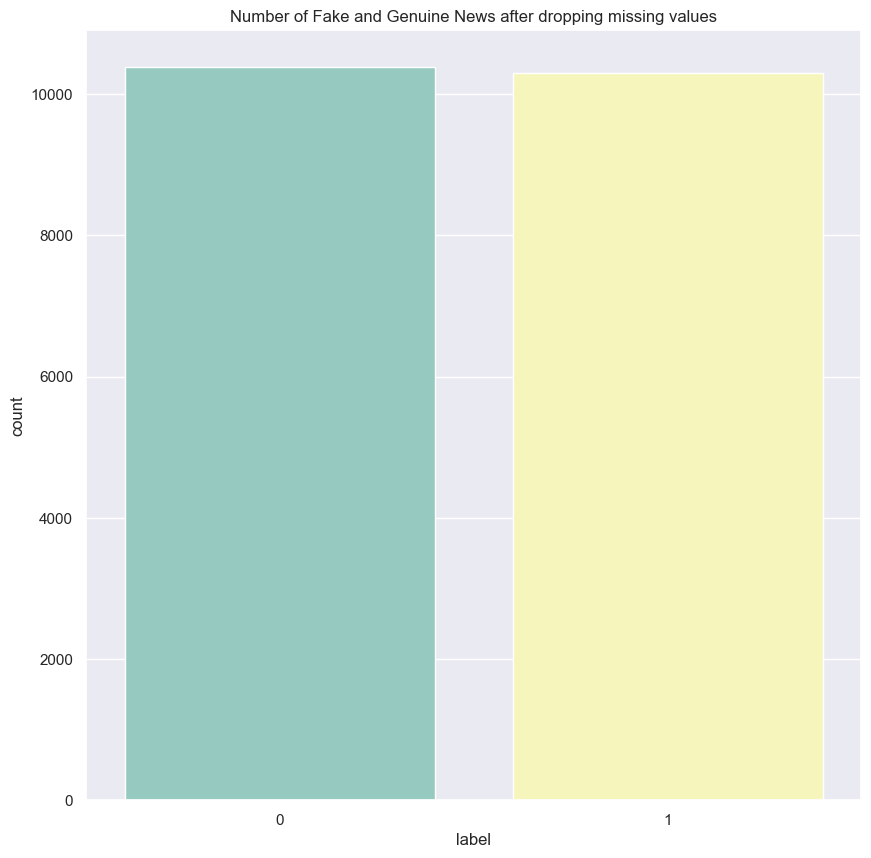

In [10]:
#Data Cleaning Combined
train_df = pd.read_csv('data/train.csv', header=0)
train_df = train_df.fillna(' ')
train_df['text'] = train_df['text'].str.strip()
train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
print(len(train_df[train_df['raw_text_length']==0]))
print(train_df.isna().sum())
train_df = train_df[train_df['raw_text_length'] > 0]
print(train_df.shape)
print(train_df.isna().sum())

# Visualize the target's distribution
sns.countplot(x='label', data=train_df, palette='Set3')
plt.title("Number of Fake and Genuine News after dropping missing values")
plt.show()

In [11]:
# Checking how individual features help in labelling data
gen_news_authors = set(list(train_df[train_df['label']==0]['author'].unique()))
fake_news_authors = set(list(train_df[train_df['label']==1]['author'].unique()))
overlapped_authors = gen_news_authors.intersection(fake_news_authors)
print("Number of distinct authors with genuine articles: {}".format(len(gen_news_authors)))
print("Number of distinct authors with fake articles: {}".format(len(fake_news_authors)))
print("Number of distinct authors with both genuine and fake: {}".format(len(overlapped_authors)))

Number of distinct authors with genuine articles: 2226
Number of distinct authors with fake articles: 1976
Number of distinct authors with both genuine and fake: 6


In [12]:
# Stylometric Analysis
# Number of Sentences per Article

from nltk import sent_tokenize
original_train_df = train_df.copy()

## Text Cleaning


In [13]:
!pip install contractions

You should consider upgrading via the 'C:\Users\Gokul\Desktop\fake-news\sem\Scripts\python.exe -m pip install --upgrade pip' command.


In [14]:
# Preserve only the Latin character, digits, and spaces. 
# Expand contractions and then convert to lower-case.
import contractions
import re
def preprocess_text(x):
  cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', x)
  word_list = []
  for each_word in cleaned_text.split(' '):
    try:
      word_list.append(contractions.fix(each_word).lower())
    except:
      print(x)
  return " ".join(word_list)

text_cols = ['text', 'title', 'author']
for col in text_cols:
  print("Processing column: {}".format(col))
  train_df[col] = train_df[col].apply(lambda x: preprocess_text(x))
  test_df[col] = test_df[col].apply(lambda x: preprocess_text(x))

Processing column: text
Processing column: title
Processing column: author


In [15]:
# Word-tokenization and stopword removal

for col in text_cols:
  print("Processing column: {}".format(col))
  train_df[col] = train_df[col].apply(word_tokenize)
  test_df[col] = test_df[col].apply(word_tokenize)

for col in text_cols:
  print("Processing column: {}".format(col))
  train_df[col] = train_df[col].apply(
    lambda x: [each_word for each_word in x if each_word not in stopwords])
  test_df[col] = test_df[col].apply(
    lambda x: [each_word for each_word in x if each_word not in stopwords])

Processing column: text
Processing column: title
Processing column: author
Processing column: text
Processing column: title
Processing column: author


## Text-Analysis

### Analysis

In [16]:
# Listing frequent words
train_df['text_joined'] = train_df['text'].apply(lambda x: " ".join(x))
test_df['text_joined'] = test_df['text'].apply(lambda x: " ".join(x))

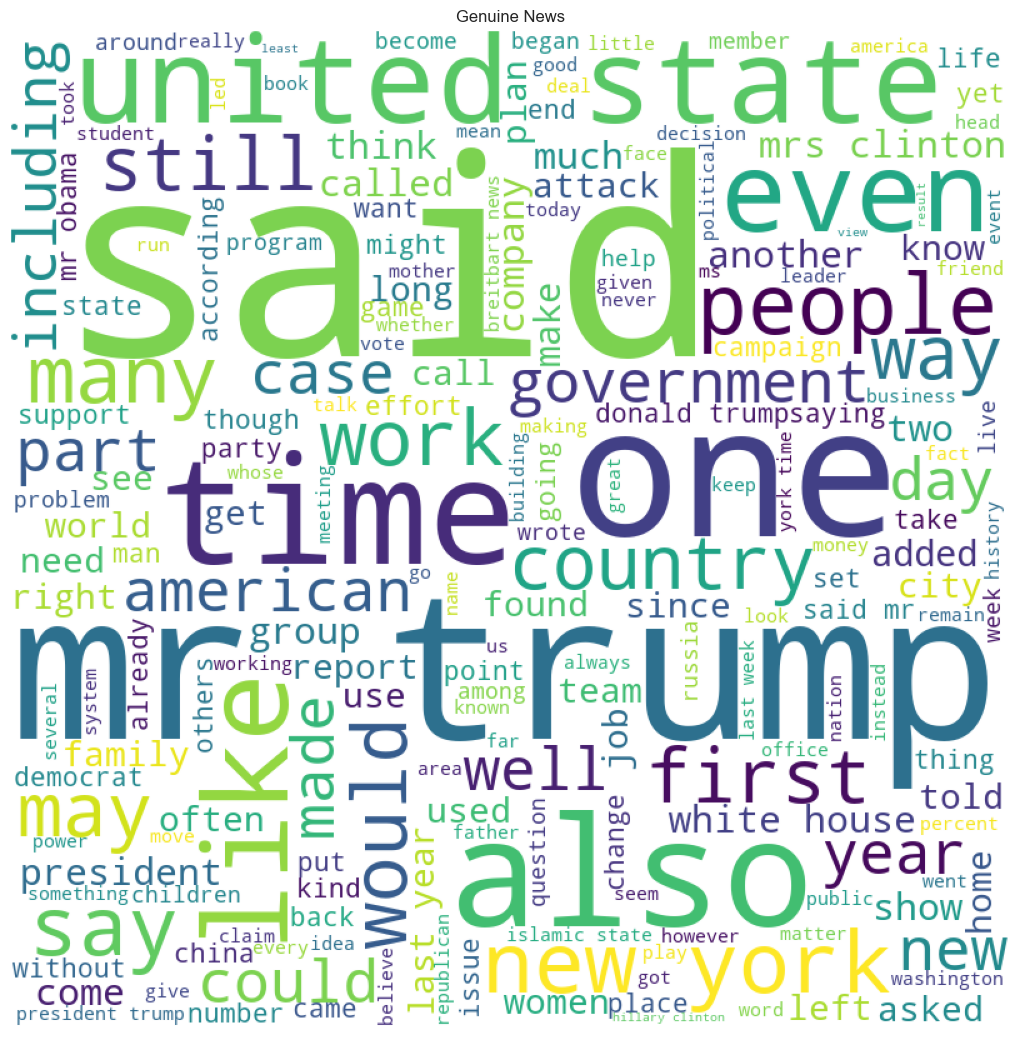

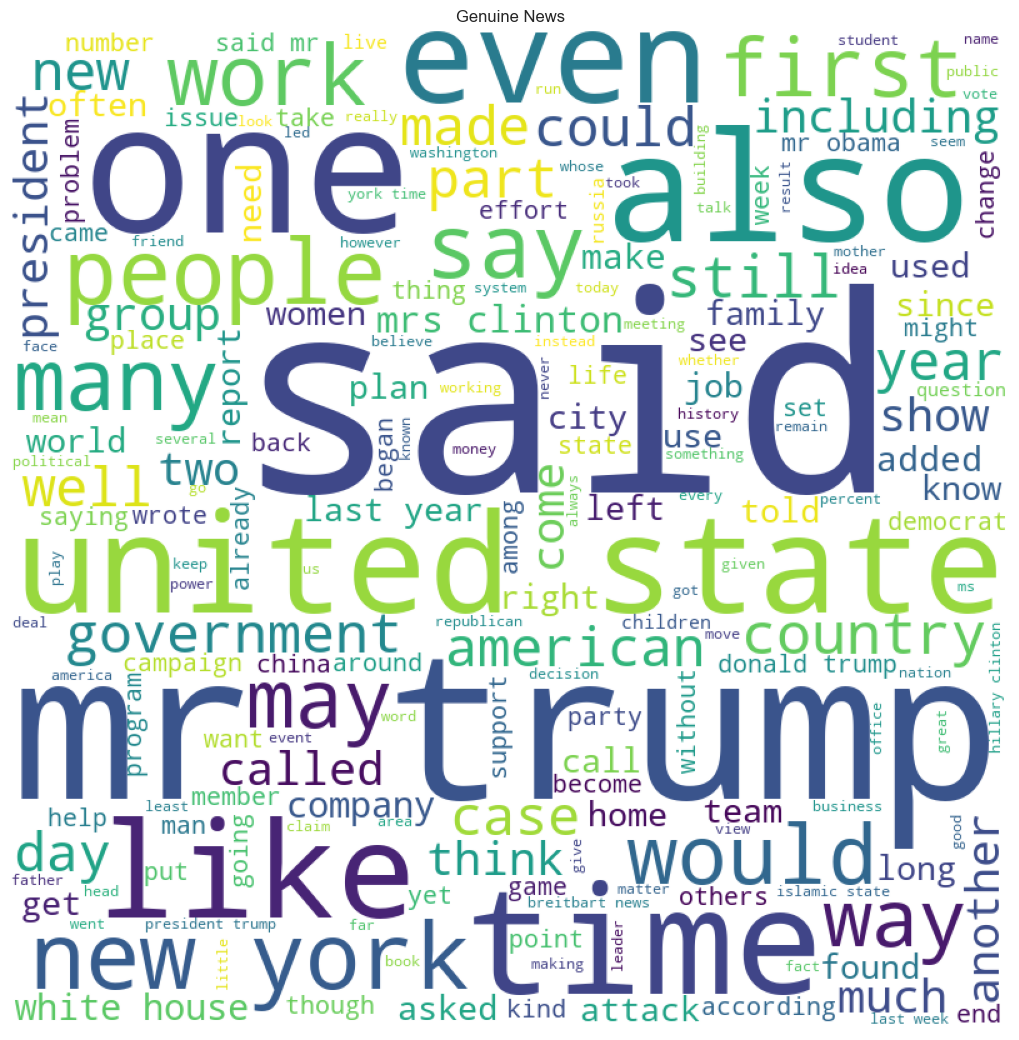

In [18]:
# Create a string of all texts and created the wordcloud

all_texts_gen = " ".join(train_df[train_df['label']==0]['text_joined'])
all_texts_fake = " ".join(train_df[train_df['label']==1]['text_joined'])

from wordcloud import WordCloud 

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_texts_gen)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Genuine News")
plt.show()

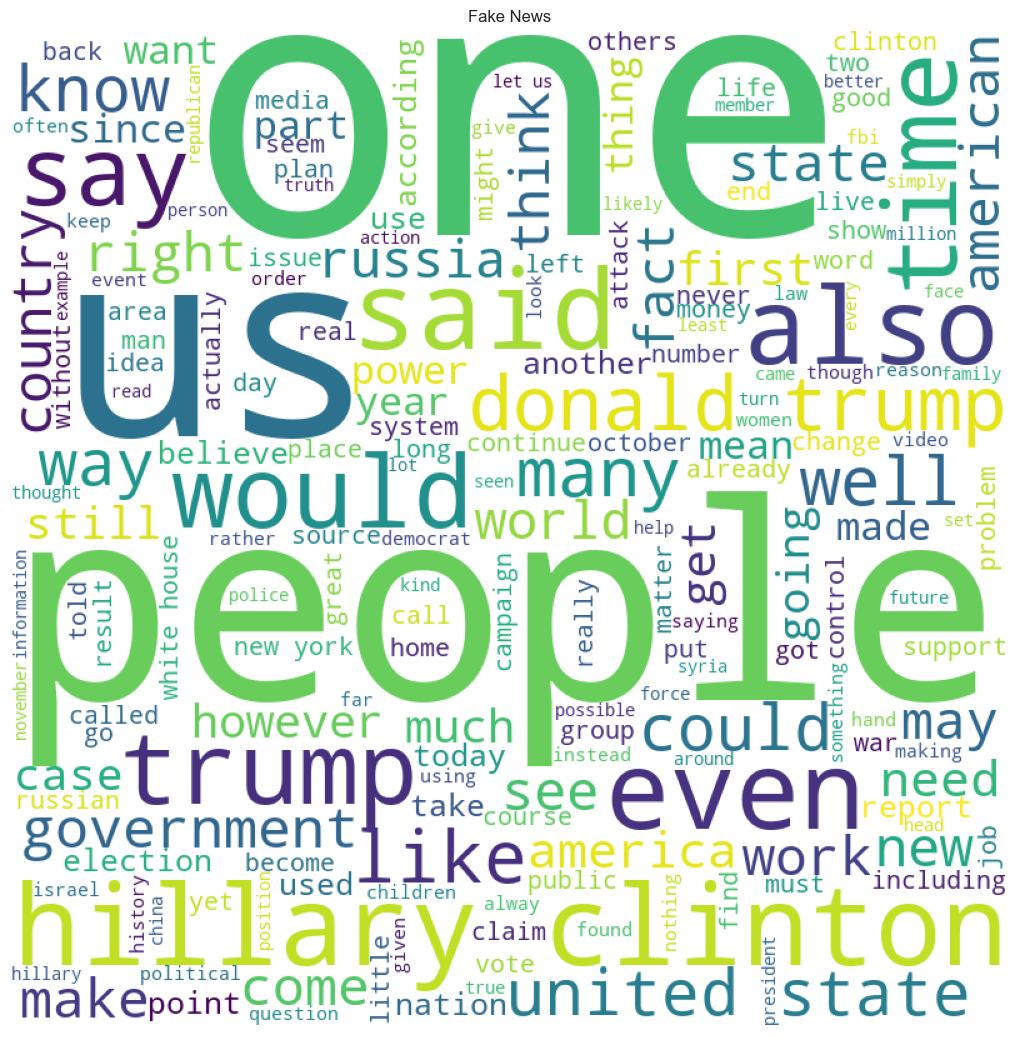

In [19]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(all_texts_fake)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Fake News")
plt.show()

In [20]:
original_train_df['sent_tokens'] = original_train_df['text'].apply(sent_tokenize)

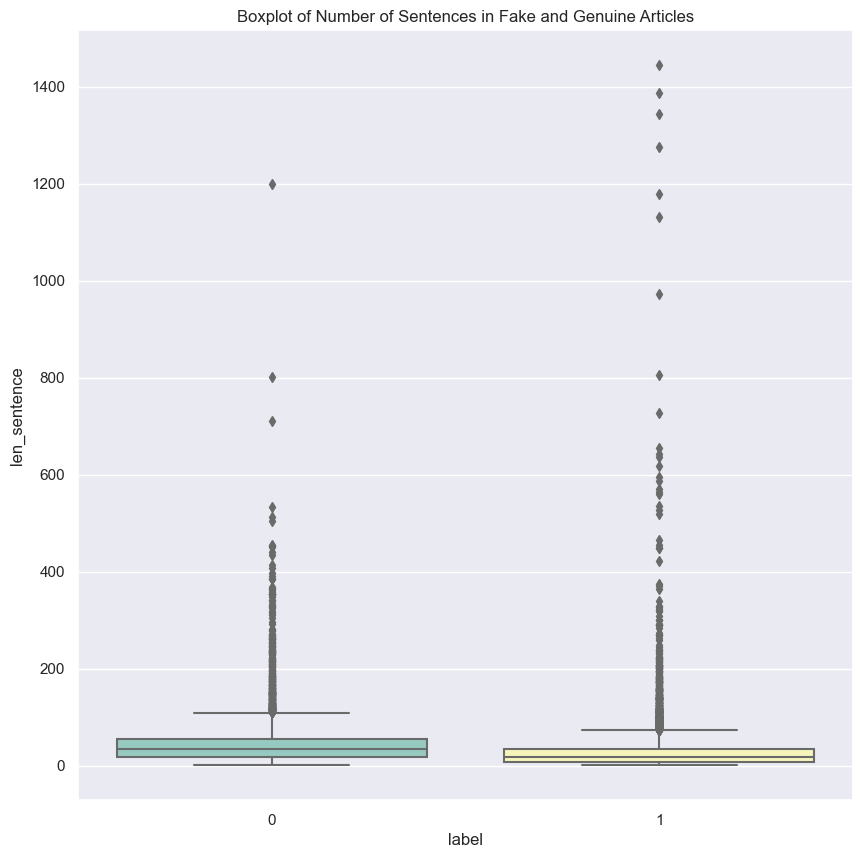

In [21]:
original_train_df['len_sentence'] = original_train_df['sent_tokens'].apply(len)
sns.boxplot(y='len_sentence', x='label', data=original_train_df, palette="Set3")
plt.title("Boxplot of Number of Sentences in Fake and Genuine Articles")
plt.show()

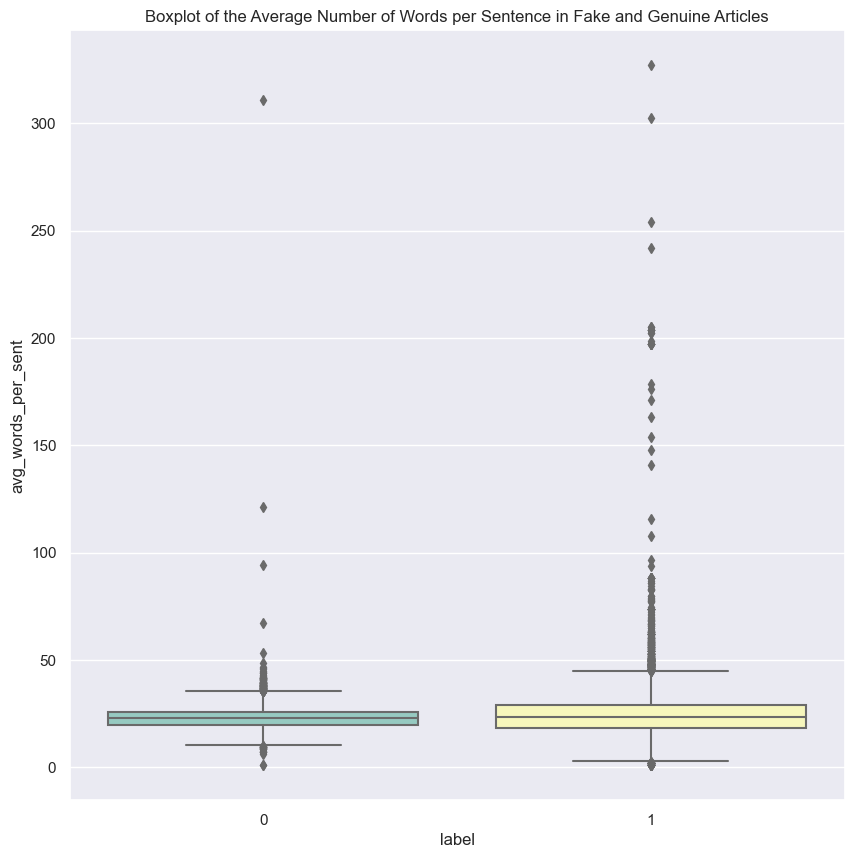

In [22]:
# Average No. of Words per Sentence Article
original_train_df['sent_word_tokens'] = original_train_df['sent_tokens'].apply(lambda x: [word_tokenize(each_sentence) for each_sentence in x])
def get_seq_tokens_cleaned(seq_tokens):
  no_punc_seq = [each_seq.translate(str.maketrans('', '', string.punctuation)) for each_seq in seq_tokens]
  sent_word_tokens = [word_tokenize(each_sentence) for each_sentence in no_punc_seq]
  return sent_word_tokens

original_train_df['sent_word_tokens'] = original_train_df['sent_tokens'].apply(lambda x: get_seq_tokens_cleaned(x))


def get_average_words_in_sent(seq_word_tokens):
  return np.mean([len(seq) for seq in seq_word_tokens])

original_train_df['avg_words_per_sent'] = original_train_df['sent_word_tokens'].apply(lambda x: get_average_words_in_sent(x))
sns.boxplot(y='avg_words_per_sent', x='label', data=original_train_df, palette="Set3")
plt.title("Boxplot of the Average Number of Words per Sentence in Fake and Genuine Articles")
plt.show()

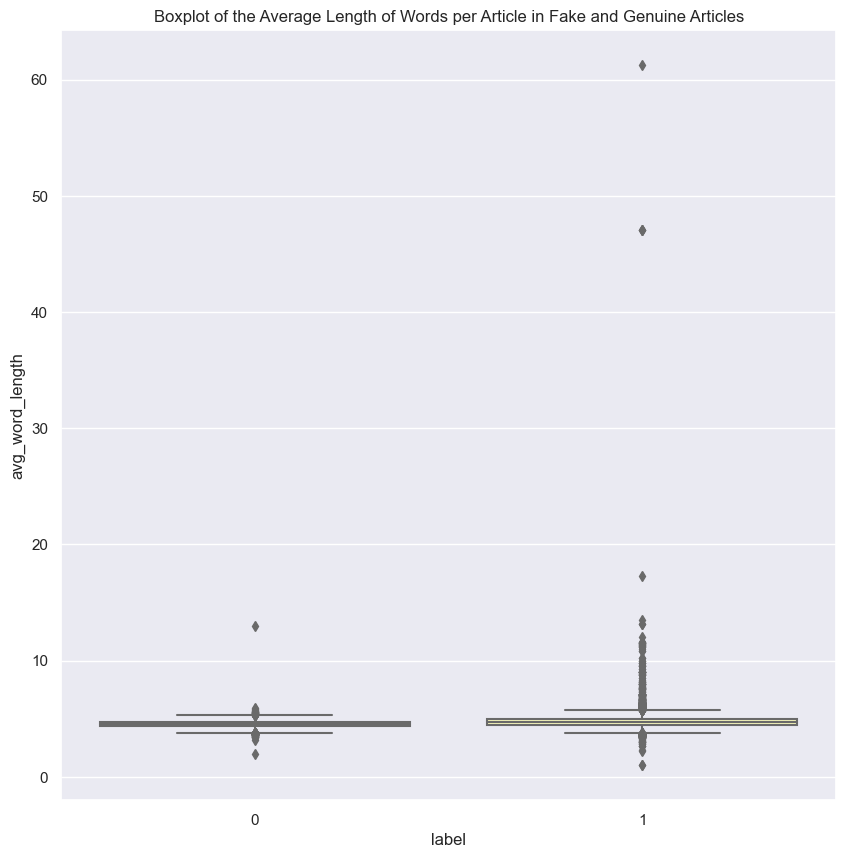

In [23]:
# Average Word Length per Article

def get_average_word_length(seq_word_tokens):
  return np.mean([len(word) for seq in seq_word_tokens for word in seq])

original_train_df['avg_word_length'] = original_train_df['sent_word_tokens'].apply(lambda x: get_average_word_length(x))

sns.boxplot(y='avg_word_length', x='label', data=original_train_df, palette="Set3")
plt.title("Boxplot of the Average Length of Words per Article in Fake and Genuine Articles")
plt.show()

In [24]:
# POS Tag Counts

all_tokenized_gen = [a for b in train_df[train_df['label']==0]['text'].tolist() for a in b]
all_tokenized_fake = [a for b in train_df[train_df['label']==1]['text'].tolist() for a in b]

len(all_tokenized_gen), len(all_tokenized_fake)

(5100290, 3701992)

In [25]:
def get_post_tags_list(tokenized_articles):
  all_pos_tags = []
  for word in tokenized_articles:
    pos_tag = nltk.pos_tag([word])[0][1]
    all_pos_tags.append(pos_tag)
  return all_pos_tags

In [ ]:
# 23 Minutes to run
all_pos_tagged_word_gen = get_post_tags_list(all_tokenized_gen)
all_pos_tagged_word_fake = get_post_tags_list(all_tokenized_fake)

In [ ]:
all_pos_tagged_word_gen[:5], all_pos_tagged_word_fake[:5]

In [ ]:
from collections import Counter
gen_pos_df = pd.DataFrame(dict(Counter(all_pos_tagged_word_gen)).items(), columns=['Pos_tag', 'Genuine News'])
fake_pos_df = pd.DataFrame(dict(Counter(all_pos_tagged_word_fake)).items(), columns=['Pos_tag', 'Fake News'])

In [ ]:
pos_df = gen_pos_df.merge(fake_pos_df, on='Pos_tag')

In [ ]:
pos_df['Genuine News'] = pos_df['Genuine News'] * 100 / pos_df['Genuine News'].sum()
pos_df['Fake News'] = pos_df['Fake News'] * 100 / pos_df['Fake News'].sum()

## Text-Classification

In [ ]:
# Tf-idf and Count Vectorizer
train_df['text_joined'] = train_df['text'].apply(lambda x: " ".join(x))
test_df['text_joined'] = test_df['text'].apply(lambda x: " ".join(x))

target = train_df['label'].values

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
tf_idf_transformer = TfidfTransformer(smooth_idf=False)

# fit train data to count vectorizer
count_vectorizer.fit(train_df['text_joined'].values)
count_vect_train = count_vectorizer.transform(train_df['text_joined'].values)

# fit ngrams count to tfidf transformers
tf_idf_transformer.fit(count_vect_train)
tf_idf_train = tf_idf_transformer.transform(count_vect_train)

In [ ]:
# Transform the test data as well
count_vect_test = count_vectorizer.transform(test_df['text_joined'].values)
tf_idf_test = tf_idf_transformer.transform(count_vect_test)

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(tf_idf_train, target, random_state=0)
df_perf_metrics = pd.DataFrame(columns=['Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision', 'Recall', 'f1_score'])

### Machine Learning Classifier Training and Validating

In [ ]:
import time
df_perf_metrics = pd.DataFrame(columns=[
    'Model', 'Accuracy_Training_Set', 'Accuracy_Test_Set', 'Precision',
    'Recall', 'f1_score', 'Training Time (secs'
])
models_trained_list = []


def get_perf_metrics(model, i):
    # model name
    model_name = type(model).__name__
    # time keeping
    start_time = time.time()
    print("Training {} model...".format(model_name))
    # Fitting of model
    model.fit(X_train, y_train)
    print("Completed {} model training.".format(model_name))
    elapsed_time = time.time() - start_time
    # Time Elapsed
    print("Time elapsed: {:.2f} s.".format(elapsed_time))
    # Predictions
    y_pred = model.predict(X_test)
    # Add to ith row of dataframe - metrics
    df_perf_metrics.loc[i] = [
        model_name,
        model.score(X_train, y_train),
        model.score(X_test, y_test),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred), "{:.2f}".format(elapsed_time)
    ]
    # keep a track of trained models
    models_trained_list.append(model)
    print("Completed {} model's performance assessment.".format(model_name))

In [ ]:
models_list = [LogisticRegression(),
               MultinomialNB(),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               GradientBoostingClassifier(),
               AdaBoostClassifier()]

In [ ]:
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

In [ ]:
df_perf_metrics

### Adding Title and Author Information to the Text
### To check if there is any improvement

In [ ]:
train_df['all_info'] = train_df['text'] + train_df['title'] + train_df['author']
train_df['all_info'] = train_df['all_info'].apply(lambda x: " ".join(x))

test_df['all_info'] = test_df['text'] + test_df['title'] + test_df['author']
test_df['all_info'] = test_df['all_info'].apply(lambda x: " ".join(x))

In [ ]:
tf_idf_transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
count_vect_train = count_vectorizer.fit_transform(train_df['all_info'].values)
tf_idf_train = tf_idf_transformer.fit_transform(count_vect_train)

X_train, X_test, y_train, y_test = train_test_split(tf_idf_train,
                                                    target,
                                                    random_state=0)

In [ ]:
# Transform the test data
count_vect_test = count_vectorizer.transform(test_df['all_info'].values)
tf_idf_test = tf_idf_transformer.transform(count_vect_test)

In [ ]:
for n, model in enumerate(models_list):
    get_perf_metrics(model, n)

In [ ]:
df_perf_metrics

### Tuning the Logistic Regression Model


In [ ]:
model = LogisticRegression()

In [ ]:
max_iter = [100, 200, 500, 1000]
C = [0.1, 0.5, 1, 10, 50, 100]

param_grid = dict(max_iter=max_iter, C=C)

In [ ]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

In [ ]:
grid_result = grid.fit(X_train, y_train)

In [ ]:
grid_result.best_estimator_

In [ ]:
grid_result.best_params_

In [ ]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('f1-score: ', f1_score(y_test, y_pred))

### Retuning the Logistic Regression Classifier

In [ ]:
model = LogisticRegression()

max_iter = [50, 75, 100]
C = [75, 100, 125]

param_grid = dict(max_iter=max_iter, C=C)

grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=['f1'],
                    refit='f1',
                    verbose=2)

grid_result = grid.fit(X_train, y_train)

In [ ]:
model = grid_result.best_estimator_
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('f1-score: ', f1_score(y_test, y_pred))

In [ ]:
grid_result.best_params_

# DL

### Text Classification using GloVe and LSTM

In [ ]:
!pip install contractions

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10,10]
import seaborn as sns
sns.set_theme(style="darkgrid")
from wordcloud import WordCloud

import contractions
import string
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from keras.layers import Flatten

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_df = pd.read_csv('train.csv', header=0)
test_df = pd.read_csv('test.csv', header=0)

In [ ]:
train_df = train_df.fillna(' ')
test_df = test_df.fillna(' ')

In [ ]:
# Combine all colums into a new one
train_df['all_info'] = train_df['text'] + train_df['title'] + train_df['author']
test_df['all_info'] = test_df['text'] + test_df['title'] + test_df['author']

In [ ]:
tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)
tokenizer.fit_on_texts(train_df['all_info'])

In [ ]:
target = train_df['label'].values

In [ ]:
max_length = 40
vocab_size = 6000

sequences_train = tokenizer.texts_to_sequences(train_df['all_info'])
sequences_test = tokenizer.texts_to_sequences(test_df['all_info'])

padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=max_length)
padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=max_length)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_train, target, test_size=0.2)

In [ ]:
X_train.shape, y_train.shape

### Binary Classification Model

In [ ]:
best_model_file_name = "models/best_model_simple.hdf5"

In [ ]:
def get_simple_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, 
                                  verbose=1, mode="min", restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, verbose=1, save_best_only=True)
]

In [ ]:
model = get_simple_model()
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=20,
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

In [ ]:
range(1, max(history.epoch) + 2)

In [ ]:
history.history.keys()

In [ ]:
metric_to_plot = "loss"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

In [ ]:
metric_to_plot = "precision"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Precision')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

In [ ]:
metric_to_plot = "recall"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Recall')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

### Using LSTM Model for Text Classification

In [ ]:
best_model_file_name = "models/best_model_simple_LSTM.hdf5"
def get_simple_LSTM_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 10, input_length=max_length))
    model.add(Dropout(0.3))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", 
                                  patience=15, 
                                  verbose=1, 
                                  mode="min", 
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, 
                                    verbose=1, 
                                    save_best_only=True)
]

model = get_simple_LSTM_model()
print(model.summary())

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

In [ ]:
metric_to_plot = "loss"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

### Using Pre-trained GloVe Embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

In [ ]:
embeddings_index = dict()
# f = open('/content/glove.6B.300d.txt')
f = open('C:/Users/nroy0/Documents/MyGitHub/Resources/glove.6B/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded {} word vectors.'.format(len(embeddings_index)))

In [ ]:
# create a weight matrix for words in training docs
print('Get vocab_size')
vocab_size = len(tokenizer.word_index) + 1

print('Create the embedding matrix')
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Simple Classification model

In [ ]:
best_model_file_name = "models/best_model_simple_with_GloVe.hdf5"

def get_simple_GloVe_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 
                        300, 
                        weights=[embedding_matrix], 
                        input_length=max_length,
                        trainable=False))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", 
                                  patience=15, 
                                  verbose=1, 
                                  mode="min", 
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, 
                                    verbose=1, 
                                    save_best_only=True)
]

model = get_simple_GloVe_model()
print(model.summary())

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

In [ ]:
metric_to_plot = "loss"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

### LSTM Model

In [ ]:
best_model_file_name = "models/best_model_LSTM_with_GloVe.hdf5"

def get_simple_GloVe_model():
    model = Sequential()
    model.add(Embedding(vocab_size, 
                        300, 
                        weights=[embedding_matrix], 
                        input_length=max_length,
                        trainable=False))
    model.add(LSTM(100))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", 
                                  patience=15, 
                                  verbose=1, 
                                  mode="min", 
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath=best_model_file_name, 
                                    verbose=1, 
                                    save_best_only=True)
]

model = get_simple_GloVe_model()
print(model.summary())

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

In [ ]:
metric_to_plot = "loss"
plt.plot(range(1, max(history.epoch) + 2), history.history[metric_to_plot], ".:", label="Training loss")
plt.plot(range(1, max(history.epoch) + 2), history.history["val_" + metric_to_plot], ".:", label="Validation loss")
plt.title('Training and Validation Loss')
plt.xlim([1,max(history.epoch) + 2])
plt.xticks(range(1, max(history.epoch) + 2))
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model(best_model_file_name)
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))